In [2]:
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline,CustomFilter
from quantopian.pipeline.factors import CustomFactor
from quantopian.pipeline.filters import Q500US
import numpy as np
import pandas as pd 
import datetime 

from __future__ import division

from quantopian.pipeline.experimental import QTradableStocksUS

## High Low Ratio 

+ 過去２５２日（一年）で、今日の価格が一番高い銘柄数と今日の価格が一番安い銘柄数の割合を出したもの
+ 詳しくはこのあたりを見てください。[New 52-week Highs and Lows [ChartSchool]](https://stockcharts.com/school/doku.php?id=chart_school:index_symbols:52_week_high_low)
+ 数字が高ければ、市場がイケイケドンドン＼(^o^)／
+ 数字が低ければ、(((( ;ﾟдﾟ))))ｱﾜﾜﾜﾜ
+ と考えることができるかもしれない、という指標です

## QTradableStocksUS

銘柄はQuantopianが作った `QTradableStocksUS()` を使います。詳しくは、[こちら](https://www.quantopian.com/help#built-in-filters)





0.58251940490458287

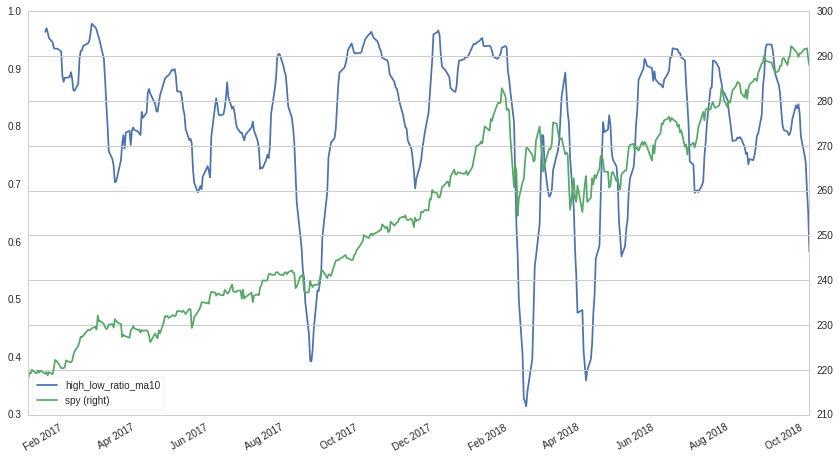

In [7]:
from quantopian.pipeline.experimental import QTradableStocksUS
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor
from quantopian.research import run_pipeline

import numpy as np

class isHighToday(CustomFactor):
    inputs = [USEquityPricing.high]
    window_length = 252
    def compute(self, today, asset_ids, out, values): 
        max_values = np.nanmax(values,axis=0)
        high_252 = max_values  == values[-1]
        out[:] =  high_252
        
class isLowToday(CustomFactor):
    inputs = [USEquityPricing.low]
    window_length = 252
    def compute(self, today, asset_ids, out, values): 
        min_values = np.nanmin(values,axis=0)
        low_252 = min_values == values[-1]
        out[:] = low_252
        

        
def make_pipeline1():
    base_universe = QTradableStocksUS()
    pipe = Pipeline()
    pipe.add(isHighToday(), "isHighToday")
    pipe.add(isLowToday(), "isLowToday")
    pipe.set_screen(base_universe)
    return pipe

start_date = '2017-01-01'
end_date = '2018-10-05'
results = run_pipeline(make_pipeline1(), 
                       start_date=start_date, 
                       end_date = end_date )

highlows = results.groupby(level=0)[["isHighToday", "isLowToday"]].sum()
highlows["high_low_ratio"] = highlows["isHighToday"] / ( highlows["isHighToday"] +  highlows["isLowToday"])
highlows["high_low_ratio_ma10"] = highlows["high_low_ratio"].rolling(10).mean()

spy = get_pricing("SPY", start_date=start_date,end_date= end_date, fields='price')
highlows["spy"] = spy
highlows[["high_low_ratio_ma10", "spy"]].plot(secondary_y = "spy")
highlows["high_low_ratio_ma10"][-1]